In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/392-crypto-currency-pairs-at-minute-resolution/gntbtc.csv
/kaggle/input/392-crypto-currency-pairs-at-minute-resolution/apeust.csv
/kaggle/input/392-crypto-currency-pairs-at-minute-resolution/kncbtc.csv
/kaggle/input/392-crypto-currency-pairs-at-minute-resolution/yfiust.csv
/kaggle/input/392-crypto-currency-pairs-at-minute-resolution/omgeth.csv
/kaggle/input/392-crypto-currency-pairs-at-minute-resolution/b2must.csv
/kaggle/input/392-crypto-currency-pairs-at-minute-resolution/dgxusd.csv
/kaggle/input/392-crypto-currency-pairs-at-minute-resolution/dotust.csv
/kaggle/input/392-crypto-currency-pairs-at-minute-resolution/neobtc.csv
/kaggle/input/392-crypto-currency-pairs-at-minute-resolution/comp-ust.csv
/kaggle/input/392-crypto-currency-pairs-at-minute-resolution/stgust.csv
/kaggle/input/392-crypto-currency-pairs-at-minute-resolution/ampust.csv
/kaggle/input/392-crypto-currency-pairs-at-minute-resolution/planets-usd.csv
/kaggle/input/392-crypto-currency-pairs-at-minute-resolut

In [2]:
print(os.listdir('/kaggle/'))
print(os.listdir('/kaggle/input'))
print(os.listdir('/kaggle/working'))
symbols = []

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from datetime import datetime
import math

for i in os.listdir('/kaggle/input/392-crypto-currency-pairs-at-minute-resolution'):
    symbols.append(i[:-4])

path = '/kaggle/input/392-crypto-currency-pairs-at-minute-resolution/'

['src', 'lib', 'input', 'working']
['392-crypto-currency-pairs-at-minute-resolution']
['__notebook__.ipynb']


In [3]:
usd_cnt = []
usdt_cnt = []
ust_cnt = []
usdc_cnt = []
busd_cnt = []
btc_cnt = []
eth_cnt = []

base = ['usd','usdt','ust','usdc','busd','btc','eth']
for symbol in symbols:
    if 'usd' in symbol and 'busd' not in symbol:
        usd_cnt.append(symbol)
    elif 'usdt' in symbol:
        usdt_cnt.append(symbol)
    elif 'ust' in symbol:
        ust_cnt.append(symbol)
    elif 'usdc' in symbol:
        usdc_cnt.append(symbol)
    elif 'busd' in symbol:
        busd_cnt.append(symbol)
    elif 'btc' in symbol:
        btc_cnt.append(symbol)
    elif 'etc' in symbol:
        etc_cnt.append(symbol)
        
print(len(usd_cnt))
print(len(usdt_cnt))
print(len(ust_cnt))
print(len(usdc_cnt))
print(len(busd_cnt))
print(len(btc_cnt))
print(len(eth_cnt))

210
0
136
0
5
70
0


# Data Summary

The original data has price data for 392 symbols but only 210 symbols are available using 'USD' as a fiat currency.

Also, many of liquid symbols are not available from the original data.

Thus, I will use 'btcusd' (Bitcoin is USD) to test a strategy.

# Strategy Summary

main idea: For the strategy test, I will mainly test 'buy-high' and 'buy-low' to see if there is a trend in the 1-minute data.

universe: BTCUSD
    
liquidity check: rolling-60-avg-usd-tradeval > 100K
    
signals: 
    
    buy-high signals:   close == rolling-50-max-close, 
        
                        close == rolling-100-max-close,
            
                        close == rolling-200-max-close,
                
                        close == rolling-500-max-close,
                    
                        close == rolling-1000-max-close
                        
    buy_low signals:    close == rolling-50-min-close,
        
                        close == rolling-100-min-close,
        
                        close == rolling-200-min-close,
                        
                        close == rolling-500-min-close,
                        
                        close == rolling-1000-min-close,
                        
trade assumption: buy at t+1 close price and sell at last holding data point close price

holding period: 
                
                10-holding period,
    
                15-holding period,
    
                20-holding period,
                
                25-holding period,
                
                30-holding period

test method: 
    
                1) original - using all signals
    
                2) filtered - using nonrepeating signals (no signals if there is an existing position)
                

training period: 
    
                (2015-01-01 - 2017-01-01)
        
                (2016-01-01 - 2018-01-01)
            
                (2017-01-01 - 2019-01-01)
                
                (2018-01-01 - 2020-01-01)
                
                (2019-01-01 - 2021-01-01)

test period: 
                
                (2021-01-01 - 2022-12-31)
                

# Strategy Class

build dataframe

build indicators

calc_cum_return

check_liquidity

build_cum_return

filter_results

show_stats

calc_avg_stats

In [4]:
class strategy:
    
    def __init__(self, symbol, min_adv, window, window2,flag):
        self.symbol = symbol
        self.min_adv = min_adv
        self.window = window
        self.window2 = window2
        self.flag = flag
        
    def build_dataframe(self):
        if 'csv' in self.symbol:
            self.symbol = self.symbol[:-4]

        df_ = pd.read_csv(path + self.symbol + '.csv')
        df_['time'] = pd.to_datetime(df_['time'], unit = 'ms')
        df_['tradeval'] = df_['close'] * df_['volume']
        df_['rolling_60_avg_tradeval'] = df_['tradeval'].rolling(60).mean()
        df_.insert(0,'symbol',[self.symbol] * len(df_)) 

        if 'Unnamed: 0' in df_.columns:
            del df_['Unnamed: 0']


        return df_
    
    def build_indicators(self,df): # ,window
    
        
        df = df.set_index(['symbol','time'])

        df['close_pct_change'] = df['close'].pct_change()
        df['close_pct_change'].fillna(0,inplace=True)

        df['close_1'] = df['close'].shift(1)

        for i in window:

            col1 = 'rolling_' + str(i) + '_close_max'
            col2 = 'rolling_' + str(i) + '_close_min'

            col3 = 'rolling_' + str(i) + '_close_1_max'
            col4 = 'rolling_' + str(i) + '_close_1_min'

            df[col1] = df['close'].rolling(i).max()
            df[col2] = df['close'].rolling(i).min()

            df[col3] = df['close_1'].rolling(i).max()
            df[col4] = df['close_1'].rolling(i).min()


        return df
    
    @staticmethod
    def calc_cum_return(df,df2,df_cum_ret,flag,date1,date2,window,window2,cost):
    
        df_ret = pd.DataFrame()
        df_ret_lst = []

        df_ = df[(df.index.get_level_values('time') >= datetime.strptime(date1, '%Y-%m-%d %H:%M:%S')) & (df.index.get_level_values('time') < datetime.strptime(date2, '%Y-%m-%d %H:%M:%S'))]
        df2_ = df2[(df2.index.get_level_values('time') >= datetime.strptime(date1, '%Y-%m-%d %H:%M:%S')) & (df2.index.get_level_values('time') < datetime.strptime(date2, '%Y-%m-%d %H:%M:%S'))]

        df1 = df2_.copy()
        df1 = df1.reset_index()
        
        if flag == 1:

            col = 'rolling_' + str(window) + '_close_max'
            df_ = df_[df_['close'] >= df_[col]] # current close price is the rolling n-day close max?
            entry_time = df_.index.get_level_values("time").tolist()

        elif flag == -1:

            col = 'rolling_' + str(window) + '_close_min'
            df_ = df_[df_['close'] <= df_[col]] # current close price is the rolling n-day close min?
            entry_time = df_.index.get_level_values("time").tolist()

        entry_time_index = df1.index[df1["time"].isin(entry_time)].tolist()

        close_time_index = [a + window2 + 1 for a in entry_time_index]

        close_time = df1[df1.index.isin(close_time_index)]["time"].tolist()

        if len(close_time) != len(close_time_index):

            close_time_index = df1.index[df1["time"].isin(close_time)].tolist()

            entry_time_index_ = [a - window2 - 1 for a in close_time_index]
            entry_time = df1[df1.index.isin(entry_time_index_)]["time"].tolist()

        if len(entry_time) > 0:
            symbol = [df1['symbol'].iloc[0]] * len(entry_time) 
            df_cum_ret_ = df_cum_ret[df_cum_ret.index.get_level_values("time").isin(entry_time)]

            if (len(symbol) == len(entry_time) == len(close_time) == len(df_cum_ret_)):
                
                df_ret = pd.DataFrame({'symbol': symbol, 'time': entry_time, 'close_time': close_time, 'net_return': df_cum_ret_['cum_return'].tolist()})
                df_ret['return'] = df_ret['net_return'] - cost
                df_ret = df_ret.set_index(['symbol','time'])

        return df_ret 
    
    def check_liquidity(self,df):
    
        df_ = df[(df['rolling_60_avg_tradeval'] > min_adv)]

        return df_ 
    
    @staticmethod
    def build_cum_ret(df,window):

        df['close_1f'] = df['close'].shift(-1)
        df['close_target_f'] = df['close'].shift(-window-1)
        df['cum_return'] = (df['close_target_f'] / df['close_1f']) - 1
        df_ret = df.loc[:,['cum_return']]

        return df_ret
    
    @staticmethod
    def filter_results(results):
    
        filtered = []
        for i in range(len(results)):

            results_ = results[i].reset_index()

            results_['close_time_1'] = results_['close_time'].shift(1)

            results1 = results_[results_['time'] > results_['close_time_1'] ]
            filtered.append(results1)
        
        
        return filtered
    
    @staticmethod
    def show_stats(results,filtered,method):
        
        df_stat = pd.DataFrame()
        df_filtered_stat = pd.DataFrame()
        import math
        for i in range(len(results)):
            total_cum_return = round(results[i][method].sum(),4)
            win = results[i][results[i][method] > 0]
            loss = results[i][results[i][method] < 0]
            avg_win_return = round(win[method].sum() / len(win),4)
            avg_loss_return = round(loss[method].sum() / len(loss),4)

            #print('original',tests[i], ' count: ', len(results[i]), ' total_return: ', total_cum_return, ' mean_return: ', round(results[i]['return'].mean(),4),' win/loss ratio: ', round(len(win) / len(results[i]),2) , ' mean_win_return: ', avg_win_return,' mean_loss_return: ', avg_loss_return )
        
            df_stat1 = pd.DataFrame({'original':[tests[i]], 'count':[len(results[i])],'total_return':[total_cum_return],'mean_return':[round(results[i]['return'].mean(),4)],'win/loss ratio':[round(len(win)/len(results[i]),2)],'mean_win_return':[avg_win_return],'mean_loss_return':[avg_loss_return]})
            df_stat = pd.concat([df_stat,df_stat1],axis=0,ignore_index=True)
            
        for i in range(len(filtered)):
            total_cum_return = round(filtered[i][method].sum(),4)
            win = filtered[i][filtered[i][method] > 0]
            loss = filtered[i][filtered[i][method] < 0]
            avg_win_return = round(win[method].sum() / len(win),4)
            avg_loss_return = round(loss[method].sum() / len(loss),4)

            #print('filtered',tests[i], ' count: ', len(filtered[i]), ' total_return: ', total_cum_return, ' mean_return: ', round(filtered[i]['return'].mean(),2),' win/loss ratio: ', round(len(win) / len(filtered[i]),2), ' mean_win_return: ', avg_win_return,' mean_loss_return: ', avg_loss_return)

        
            df_stat2 = pd.DataFrame({'filtered':[tests[i]], 'count':[len(filtered[i])],'total_return':[total_cum_return],'mean_return':[round(filtered[i]['return'].mean(),4)],'win/loss ratio':[round(len(win)/len(filtered[i]),2)],'mean_win_return':[avg_win_return],'mean_loss_return':[avg_loss_return]})
            df_filtered_stat = pd.concat([df_filtered_stat,df_stat2],axis=0,ignore_index=True)
            
        
        return df_stat, df_filtered_stat
    
    @staticmethod
    def calc_avg_stats(df_stat,df_filtered_stat):

        df_new = pd.DataFrame()
        for i in range(25):
            df_ = df_stat[df_stat.index == i]
            title = df_['original'].iloc[0]
            df1 = df_.mean().to_frame().T
            df1.insert(0,'original',[title])
            df_new = df_new.append(df1,ignore_index=True)
        
        df_new_filtered = pd.DataFrame()
        for i in range(25):
            df_ = df_filtered_stat[df_filtered_stat.index == i]
            title = df_['filtered'].iloc[0]
            df1 = df_.mean().to_frame().T
            df1.insert(0,'filtered',[title])
            df_new_filtered = df_new_filtered.append(df1,ignore_index=True)
        
        print(df_new)
        print(df_new_filtered)
        return df_new,df_new_filtered

# Parameters

In [5]:
min_adv = 100000 # rolling 60 avg tradeval
symbol = "btcusd"

window = [50,100,200,500,1000]
window2 = [10,15,20,25,30]

# Training Period
start = pd.date_range("2015-01-01 00:00:00", periods = 5, freq = '1AS')
end = pd.date_range("2017-01-01 00:00:00", periods = 5, freq = '1AS')

training_periods = [(a.strftime("%Y-%m-%d %H:%M:%S"),b.strftime("%Y-%m-%d %H:%M:%S")) for a,b in zip(start, end)]
print(training_periods)

# train 
train_start1 = "2015-01-01 00:00:00"
train_end1 = "2021-01-01 00:00:00" 

# test
test_start = "2021-01-01 00:00:00"
test_end = "2022-12-31 00:00:00"

test_period = [(test_start,test_end)]


[('2015-01-01 00:00:00', '2017-01-01 00:00:00'), ('2016-01-01 00:00:00', '2018-01-01 00:00:00'), ('2017-01-01 00:00:00', '2019-01-01 00:00:00'), ('2018-01-01 00:00:00', '2020-01-01 00:00:00'), ('2019-01-01 00:00:00', '2021-01-01 00:00:00')]


# Training Period

# Buy-High Signals

In [6]:
flag = 1
cost = 0.0001
#period = [(test_start,test_end)]
df_stat = pd.DataFrame()
df_filtered_stat = pd.DataFrame()
strat = strategy(symbol, min_adv, window, window2,flag)
df_symbol = strat.build_dataframe()
df_symbol = strat.build_indicators(df_symbol)
df_symbol_liquid = strat.check_liquidity(df_symbol)

for period in training_periods:
    period = [period]
    print(period)
    results = []
    tests = []

    for w in range(len(window)):

        for w2 in range(len(window2)):

            df_ret = strat.build_cum_ret(df_symbol,window2[w2])
            df_combined = pd.DataFrame()
            for i in period:
            
                df_ = strat.calc_cum_return(df_symbol_liquid,df_symbol,df_ret,flag,i[0],i[1],window[w],window2[w2],cost)
                
                df_combined = pd.concat([df_combined,df_])

            title = 'rolling_' + str(window[w]) + '_max_hold_' + str(window2[w2])
            
            tests.append(title)
            results.append(df_combined)

    filtered = strat.filter_results(results)
    df_new_stat,df_new_filtered_stat = strat.show_stats(results,filtered,'net_return') # net_return: without cost, return: with cost
    
    df_stat = df_stat.append(df_new_stat)
    df_filtered_stat = df_filtered_stat.append(df_new_filtered_stat)

# average of 5 sessions results in the traing period
df_avg_stat, df_avg_filtered_stat = strat.calc_avg_stats(df_stat,df_filtered_stat)

[('2015-01-01 00:00:00', '2017-01-01 00:00:00')]
[('2016-01-01 00:00:00', '2018-01-01 00:00:00')]
[('2017-01-01 00:00:00', '2019-01-01 00:00:00')]
[('2018-01-01 00:00:00', '2020-01-01 00:00:00')]
[('2019-01-01 00:00:00', '2021-01-01 00:00:00')]
                    original    count  total_return  mean_return  \
0     rolling_50_max_hold_10  14578.0      -5.23522     -0.00066   
1     rolling_50_max_hold_15  14578.0      -5.80342     -0.00076   
2     rolling_50_max_hold_20  14577.8      -5.84688     -0.00072   
3     rolling_50_max_hold_25  14577.2      -5.94922     -0.00080   
4     rolling_50_max_hold_30  14577.2      -5.85176     -0.00088   
5    rolling_100_max_hold_10   9943.8      -3.56364     -0.00070   
6    rolling_100_max_hold_15   9943.8      -3.93118     -0.00088   
7    rolling_100_max_hold_20   9943.8      -4.15282     -0.00084   
8    rolling_100_max_hold_25   9943.8      -4.48044     -0.00094   
9    rolling_100_max_hold_30   9943.8      -4.55472     -0.00088   
10   ro

# Buy-Low Signals

In [7]:
flag = -1
cost = 0.0001
#period = [(test_start,test_end)]
df_min_stat = pd.DataFrame()
df_min_filtered_stat = pd.DataFrame()
strat = strategy(symbol, min_adv, window, window2,flag)
df_symbol = strat.build_dataframe()
df_symbol = strat.build_indicators(df_symbol)
df_symbol_liquid = strat.check_liquidity(df_symbol)

for period in training_periods:
    period = [period]
    print(period)
    results = []
    tests = []

    for w in range(len(window)):

        for w2 in range(len(window2)):

            df_ret = strat.build_cum_ret(df_symbol,window2[w2])
            df_combined = pd.DataFrame()
            for i in period:
            
                df_ = strat.calc_cum_return(df_symbol_liquid,df_symbol,df_ret,flag,i[0],i[1],window[w],window2[w2],cost)
                
                
                df_combined = pd.concat([df_combined,df_])
                

            title = 'rolling_' + str(window[w]) + '_min_hold_' + str(window2[w2])
            
            tests.append(title)
            results.append(df_combined)

    filtered = strat.filter_results(results)
    df_new_stat,df_new_filtered_stat = strat.show_stats(results,filtered,'net_return') # net_return: without cost, return: with cost
    
    df_min_stat = df_min_stat.append(df_new_stat)
    df_min_filtered_stat = df_min_filtered_stat.append(df_new_filtered_stat)

# average of 5 sessions results in the traing period
df_avg_min_stat, df_avg_min_filtered_stat = strat.calc_avg_stats(df_min_stat,df_min_filtered_stat)

[('2015-01-01 00:00:00', '2017-01-01 00:00:00')]
[('2016-01-01 00:00:00', '2018-01-01 00:00:00')]
[('2017-01-01 00:00:00', '2019-01-01 00:00:00')]
[('2018-01-01 00:00:00', '2020-01-01 00:00:00')]
[('2019-01-01 00:00:00', '2021-01-01 00:00:00')]
                    original    count  total_return  mean_return  \
0     rolling_50_min_hold_10  12747.8      11.87662      0.00364   
1     rolling_50_min_hold_15  12747.4      12.37522      0.00458   
2     rolling_50_min_hold_20  12747.4      12.63616      0.00460   
3     rolling_50_min_hold_25  12747.4      13.29238      0.00448   
4     rolling_50_min_hold_30  12747.4      14.71958      0.00546   
5    rolling_100_min_hold_10   8508.4       9.68852      0.00402   
6    rolling_100_min_hold_15   8508.0      10.26016      0.00514   
7    rolling_100_min_hold_20   8508.0      10.66412      0.00506   
8    rolling_100_min_hold_25   8508.0      11.39936      0.00486   
9    rolling_100_min_hold_30   8508.0      12.59358      0.00592   
10   ro

# Training Backtest Analysis

Bitcoin shows mean-reversion movement from both 'buy-high' and 'buy-low'.

By changing the holding period from 10-minute to 30-minute, I also found that there is a strong mean-reversion trend in all tested cases.

Especially,the mean-reversion is more strong from 'buy-low' as both the performance using all signals and the performance using nonrepeating signals are strong.

The mean-reversion from 'buy-high' is also observed as 'buy-high' generates strong negative results using all signals. 

However, 'buy-high' shows no clear pattern when not buying if there is an existing position.

Thus, for the test period, I will use 'buy-low'signal. 

# Test Period

# Buy-Low Signals

In [8]:
flag = -1
cost = 0.0001
#period = [(test_start,test_end)]
df_min_stat = pd.DataFrame()
df_min_filtered_stat = pd.DataFrame()

results = []
tests = []
strat = strategy(symbol, min_adv, window, window2,flag)
df_symbol = strat.build_dataframe()
df_symbol = strat.build_indicators(df_symbol)
df_symbol_liquid = strat.check_liquidity(df_symbol)

for w in range(len(window)):

    for w2 in range(len(window2)):

        df_ret = strat.build_cum_ret(df_symbol,window2[w2])
        df_combined = pd.DataFrame()
        for i in test_period:

            df_ = strat.calc_cum_return(df_symbol_liquid,df_symbol,df_ret,flag,i[0],i[1],window[w],window2[w2],cost)


            df_combined = pd.concat([df_combined,df_])


        title = 'rolling_' + str(window[w]) + '_min_hold_' + str(window2[w2])
        
        tests.append(title)
        results.append(df_combined)

    filtered = strat.filter_results(results)
    df_new_stat,df_new_filtered_stat = strat.show_stats(results,filtered,'net_return') # net_return: without cost, return: with cost
    
    df_min_stat = df_min_stat.append(df_new_stat)
    df_min_filtered_stat = df_min_filtered_stat.append(df_new_filtered_stat)

# average of 5 sessions results in the traing period
df_min_stat, df_min_filtered_stat = strat.calc_avg_stats(df_min_stat,df_min_filtered_stat)

                    original    count  total_return  mean_return  \
0     rolling_50_min_hold_10  33111.0       11.6946       0.0003   
1     rolling_50_min_hold_15  33111.0       14.5836       0.0003   
2     rolling_50_min_hold_20  33111.0       17.6653       0.0004   
3     rolling_50_min_hold_25  33111.0       20.8817       0.0005   
4     rolling_50_min_hold_30  33111.0       20.9523       0.0005   
5    rolling_100_min_hold_10  22866.0       10.0061       0.0003   
6    rolling_100_min_hold_15  22866.0       12.0661       0.0004   
7    rolling_100_min_hold_20  22866.0       14.7964       0.0005   
8    rolling_100_min_hold_25  22866.0       18.1077       0.0007   
9    rolling_100_min_hold_30  22866.0       18.3560       0.0007   
10   rolling_200_min_hold_10  16589.0        8.4567       0.0004   
11   rolling_200_min_hold_15  16589.0       10.2770       0.0005   
12   rolling_200_min_hold_20  16589.0       12.8325       0.0007   
13   rolling_200_min_hold_25  16589.0       15.6

# Test Backtest Analysis

Based on the backtest using test dataset, 'buy-low' for rolling-50-min-close outperforms other test cases.

Also, 'buy-low' for rolling-50-min-close test case shows a monotonic trend, better performance by holding longer.

Especially, the test dataset includes year 2021 and year 2022 which are opposit to each other, year 2021: bull-market, year 2022: bear-market.
        
By choosing nonreapting signal type, investors can make a full position for each signal.        

In [9]:
filtered[4] # buy-low for rolling-50-min-close

,symbol,time,close_time,net_return,return,close_time_1
1,btcusd,2021-01-01 02:13:00,2021-01-01 02:44:00,0.000000,-0.000100,2021-01-01 00:44:00
5,btcusd,2021-01-01 12:05:00,2021-01-01 12:36:00,0.012515,0.012415,2021-01-01 03:12:00
6,btcusd,2021-01-01 12:54:00,2021-01-01 13:25:00,0.004135,0.004035,2021-01-01 12:36:00
7,btcusd,2021-01-01 14:45:00,2021-01-01 15:16:00,-0.000578,-0.000678,2021-01-01 13:25:00
19,btcusd,2021-01-01 17:39:00,2021-01-01 18:10:00,0.002913,0.002813,2021-01-01 16:08:00
...,...,...,...,...,...,...
33073,btcusd,2022-09-12 13:37:00,2022-09-12 14:08:00,0.004001,0.003901,2022-09-12 12:57:00
33074,btcusd,2022-09-12 14:40:00,2022-09-12 15:11:00,-0.002347,-0.002447,2022-09-12 14:08:00
33093,btcusd,2022-09-13 00:18:00,2022-09-13 00:49:00,-0.003299,-0.003399,2022-09-12 16:42:00
33101,btcusd,2022-09-13 06:42:00,2022-09-13 07:13:00,-0.002012,-0.002112,2022-09-13 01:08:00


1.4426108925140781 0.9666108925140706


[]

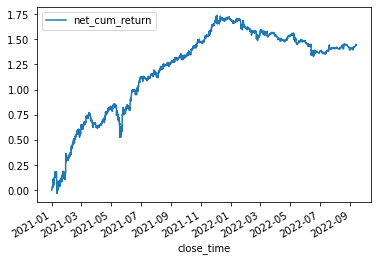

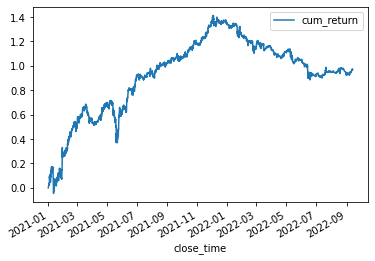

In [10]:
filtered[4]['net_cum_return'] = filtered[4]['net_return'].cumsum() # no cost
filtered[4]['cum_return'] = filtered[4]['return'].cumsum() # cost: 1 basis point

print(filtered[4]['net_cum_return'].iloc[-1], filtered[4]['cum_return'].iloc[-1])

filtered[4].plot(kind='line',x = 'close_time', y = 'net_cum_return' )
filtered[4].plot(kind='line',x = 'close_time', y = 'cum_return' )

plt.plot()